<a href="https://colab.research.google.com/github/shinjangwoon/TIL/blob/master/Data%20Analysis/%EC%84%9C%ED%8F%AC%ED%8A%B8_%EB%B2%A1%ED%84%B0_%EB%A8%B8%EC%8B%A0(SVM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 서포트 벡터 머신(SVM)
- 선형이나 비선형 분류, 회귀, 이상치 탐색에도 사용할 수 있는 다목적 모델

In [38]:
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 선형 SVM 분류


In [39]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

그림 저장: large_margin_classification_plot


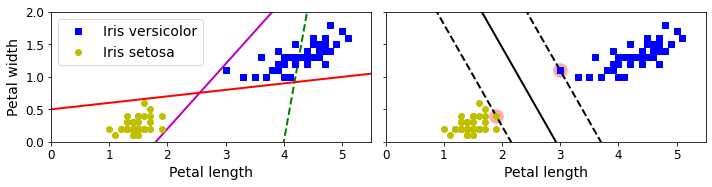

In [40]:
# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()


- 왼쪽 그래프에 세 개의 선형 분류기에서 만들어진 결정 경계가 보임 ( 결정 경계 - 기본 벡터공간을 각 클래스에 대하여 하나씩 두 개의 집합으로 나누는 초표면)
    - 점선으로 나타난 결정 경계룰 만든 모델은 클래스를 적절하게 분류하지 못하고 있음(왼쪽의 결정 경계는 설명을 위해 임의의 직선을 그은 것)
    - 다른 두 모델은 훈련세트에 대해 왼벽하게 동작하겠지만 결정 경계가 샘플에 가까워 새로운 샘플에 대해서는 잘 작동하지 않을 것임

- 오른쪽 그래래프에 있는 실선은 SVM 분류기의 결정 경계
    - 두 개의 클래스를 나누고 있을 뿐만 아니라 제일 가까운 훈련 샘플로부터 가능한 한 멀리 떨어져 있음
    - SVM 분류기를 클래스 사이에 가장 폭이 넓은 도로를 찾는 것으로 생각할 수 있음 ( 그래서 라지 마진 분류라고도 부름)

- 도로 바깥쪽에 훈련 샘플을 더 추가해도 결정 경계에는 전혀 영향을 미치지 않음
- 도로 경계에 위치한 샘플에 의해 전적으로 결정(의지)됨.
- 이런 샘플을 서포트 벡터라고 함(그래프에선 o표시)


### 특성 스케일에 따른 민감성

그림 저장: sensitivity_to_feature_scales_plot


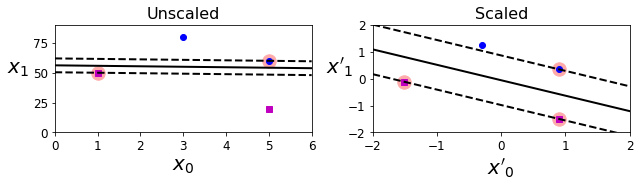

In [41]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")

- SVM은 특성 스케일에 민감함
    - 왼쪽 그래프에서는 수직축의 스케일이 수평축의 스케일보다 훨씬 커서 가장 넓은 도로가 거의 수평에 가깝게 됨
    - 특성의 스케일을 조정하면(ex. 사이킷런의 StandardScaler)를 사용하여 결정 경계가 훨씬 좋아짐(오른쪽 그래프)

## 소프트 마진 분류

- 모든 샘플이 도로 바깥쪽에 올바르게 분류되어 있다면 이를 하드마진분류라고 함
    - 데이터가 선형적으로 구분될 수 있어야 제대로 작동하며, 이상치에 민감하다는 두 가지 문제점
    ``

그림 저장: sensitivity_to_outliers_plot


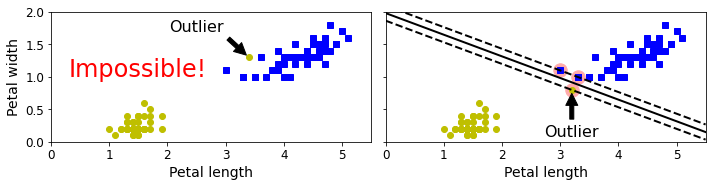

In [42]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

- 왼쪽 그래프에서는 하드 마진을 찾을 수 없음
- 오른쪽 그래프는 일반화가 잘될 것 같지 않음

- 이러한 문제를 피하려면 좀 더 유연한 모델이 필요
    - 도로의 폭을 가능한 한 넓게 유지하는 것과 마진오류(샘플이 도로 중간이나 심지어 반대쪽에 있는 경우) 사이에 적절한 균형을 잡아야 함
    - 이를 소프트 마진 분류라고 함
    

In [43]:
# 붓꽃 데이터셋을 적재하고, 특성 스케일을 변경하여 Iris-Virginia 품종을 감지하기 위해 선형 SVM 모델을 훈련
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [44]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

- SVM 분류기는 로지스틱 회귀 분류기와는 다르게 클래스에 대한 확률을 제공하지 않음

In [45]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [46]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

그림 저장: regularization_plot


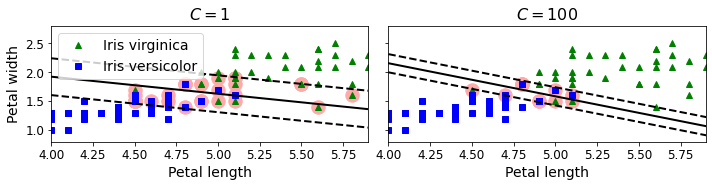

In [47]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

- 사이킷런의 SVM 모델을 만들 때 여러 하이퍼파라미터를 지정할 수 있음
- C는 이런 하이퍼파라미터 중에 하나임
    - 이를 낮게 설정하면 왼쪽과 같은 모델을 만들고, 반대로 높게 설정하면 오른쪽과 같은 모델을 얻음
- 마진 오류는 나쁘므로 일반적으로 적은 것이 좋음. 하지만 이 경우 왼쪽 모델에 마진 오류가 많지만 일반화는 더 잘 될 것 같음
- SVM 모델이 과대적합이라면 C를 감소시켜 모델을 규제할 수 있음

## 비선형 SVM 분류

그림 저장: higher_dimensions_plot


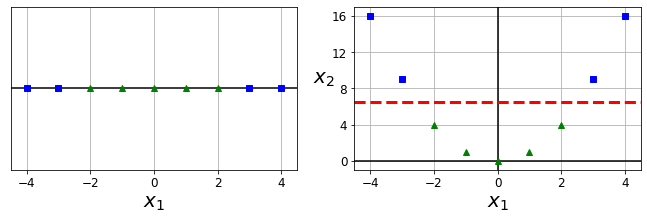

In [48]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

- 왼쪽의 그래프는 하나의 특성 X1만을 가진 간단한 데이터셋을 나타내지만 선형적으로 구분이 안됨
- 하지만 두 번째 특성 X2 = (X1)**2를 추가하여 만들어진 2차원 데이터셋은 완벽하게 선형적으로 구분가능

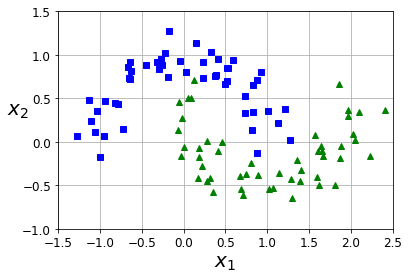

In [49]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [50]:
from numpy.lib import polynomial
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = make_moons(n_samples=100, noise=0.15)
polynomial_svm_clf = Pipeline([
                               ("poly_features", PolynomialFeatures(degree=3)),
                               ("scaler", StandardScaler()),
                               ("svm_clf", LinearSVC(C=10, loss='hinge'))  
])
polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge'))])

그림 저장: moons_polynomial_svc_plot


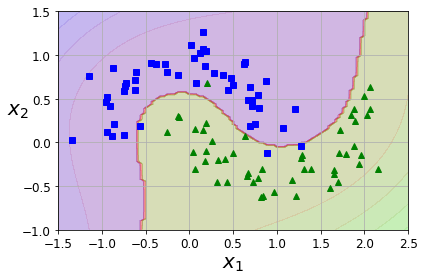

In [51]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## 다항식 커널

- 커널 트릭은 실제로는 특성을 추가하지 않으면서 다항식 특성을 많이 추가한 것과 같은 결과를 얻을 수 있음
    - 사실 어떤 특성도 추가하지 않기 때문에 엄청난 수의 특성 조합이 생기지 않음

In [52]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)) # 매개변수 coef0은 모델이 높은 차수와 낮은 차수에 얼마나 영향을 받을지 조절
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [53]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

그림 저장: moons_kernelized_polynomial_svc_plot


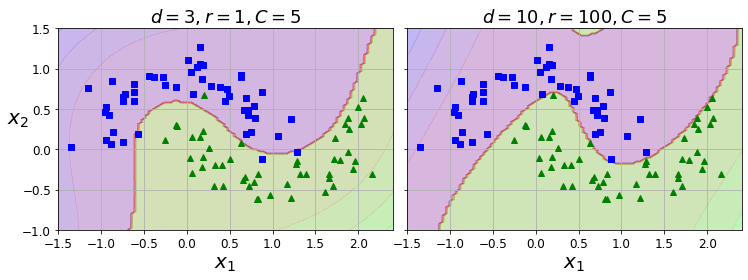

In [54]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)

plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

- 3차 다항식 커널을 사용해 SVM 분류기를 훈련시킴
    - 결과는 왼쪽 그래프
- 오른쪽 그래프는 10차 다항식 커널을 사용한 또 다른 SVM 분류기임
- 모델이 과대적합이라면 다항식의 차수를 줄여야 함
- 반대로 과소적합이라면 차수를 늘려야 함


## 유사도 특성

- 비선형 특성을 다루는 또 다른 기법은 각 샘플이 특정 랜드마크와 얼마나 닮았는지 측정하는 유사도 함수로 계산한 특성을 추가하는 것

그림 저장: kernel_method_plot


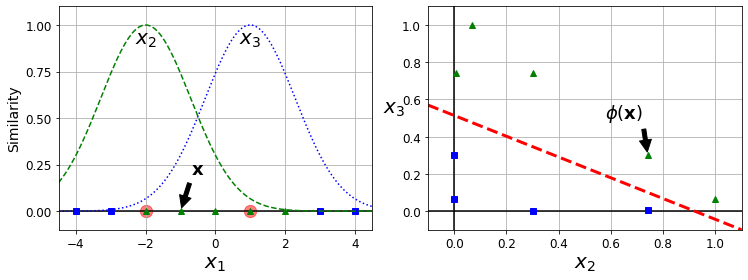

In [55]:
# 가우시안 RBF를 사용한 유사도 특성
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

In [56]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))


Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


## 가우시안 방사 기저 함수(RBF) 커널

In [57]:
rbf_kernel_svm_clf = Pipeline([
                               ('scaler', StandardScaler()),
                               ('svm_clf', SVC(kernel='rbf', gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

그림 저장: moons_rbf_svc_plot


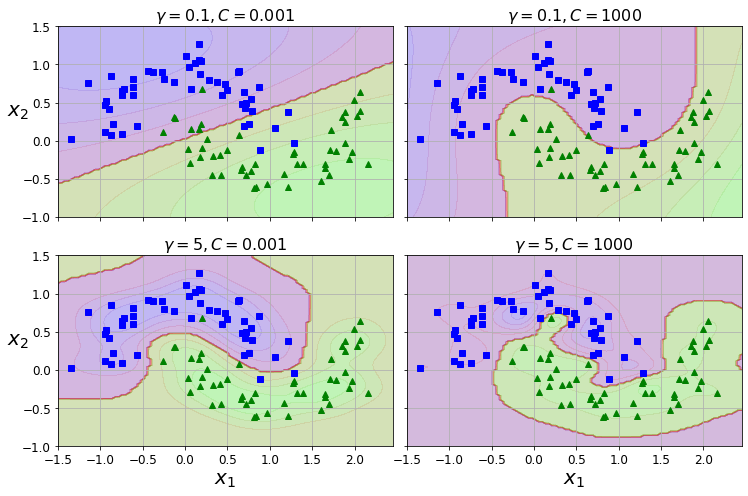

In [58]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

- gamma를 증가시키면 종 모양 그래프가 좁아져서 각 샘플의 영향 범위가 작아지며,
결정 경계가 조금 더 불규칙해지고 각 샘플을 따라 구붉구불하게 휘어짐

- 반대로 작은 gamma 값은 넓은 종 모양 그래프를 만드며 샘플이 넓은 범위에 걸쳐 영향을 주므로 
결정 경계가 더 부드러워짐

- 결국 하이퍼파라미터(gamma)가 규제의 역할을 함
- 모델이 과대적합일 경우엔 감소시켜야하고 괴소적합일 경우엔 증가시켜야함(하이퍼파라미터 C와 비슷)

## 계산 복잡도

- LinearSVC 파이썬 클래스는 선형 SVM을 위한 최적화된 알고리즘을 구현한 liblinear 라이브러리를 기반으로 함
(커널 트릭을 지원하지 않지만 훈련 샘플과 특성 수에 거의 선형적으로 늘어남
이 알고리즘의 훈련 시간 복잡도는 O(m * n)정도)

- 정밀도를 높이면 알고리즘의 수행 시간이 길어짐
이는 허용오차 하이퍼 파라미터로 조절(사이킷런에서는 매개변수 tol임)
대부분의 분류 문제는 허용오차를 기본값으로 두면 잘 작동함

- SVC는 커널 트릭 알고리즘을 구현한 libsvm 라이브러리를 기반으로 함
복잡하지만 작거나 중간 규모의 훈련 세트에 이 알고리즘이 잘 맞음
하지만 특성의 개수에는, 특히 희소 특성(각 샘플에 0이 아닌 특성이 몇 개 없는 경우)인 경우에 잘 확장됨. 이런 경우 알고리즘의 성능이 샘플이 가진 0이 아닌 특성의 평균 수에 거의 비례함

## SVM 회귀
- 일정한 마진 오류 안에서 두 클래스 간의 도로 폭이 가능한 한 최대가 되도록 하는 대신, SVM 회귀는 제한된 마진 오류(즉, 도로 밖의 샘플) 안에서 도로 안에 가능한 한 많은 샘플이 들어가도록 학습

In [59]:
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [60]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

In [61]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그림 저장: svm_regression_plot


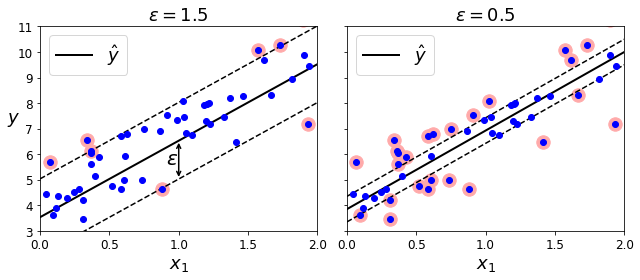

In [62]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

- 무작위로 생성한 선형 데이터셋에 훈련시킨 두 개의 선형 SVM 회귀 모델을 보여줌
    - 왼쪽은 마진을 크게하고 오른쪽은 마진을 작게 하여 만들었음

- 마진 안에서는 훈련 샘플이 추가되어도 모델의 예측에는 영향이 없음
    - 그래서 이 모델을 마진에 민감하지 않다고 말함

In [63]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [64]:
# 사이킷런의 LinearSVR을 사용해 선형 SVM 회귀를 적용
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

In [65]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

그림 저장: svm_with_polynomial_kernel_plot


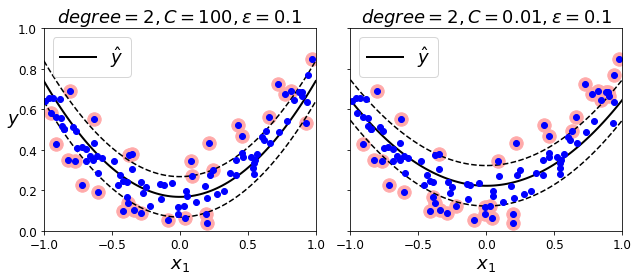

In [66]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

- 임의의 2차방정식 형태의 훈련 세트에 2차 다항 커널을 사용한 SVM 회귀를 보여줌
    - 왼쪽은 규제가 거의 없고(큰 C), 오른쪽은 규제가 훨씬 많음(작은 C)

## 결정 함수와 예측

In [67]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

그림 저장: iris_3D_plot


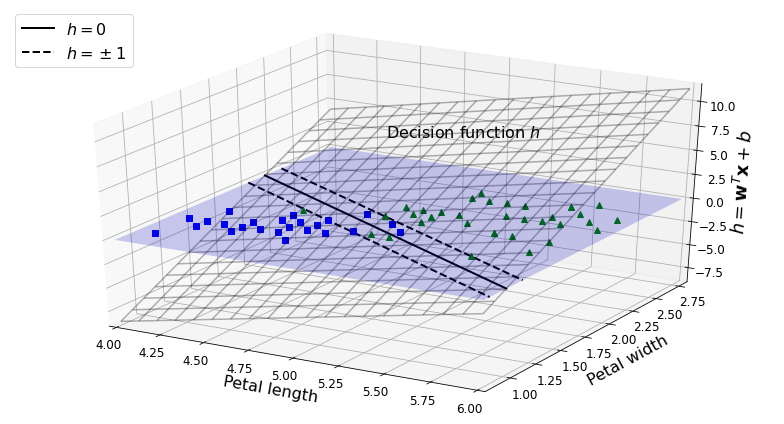

In [68]:
# iris 함수의 결정 함수
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

그림 저장: small_w_large_margin_plot


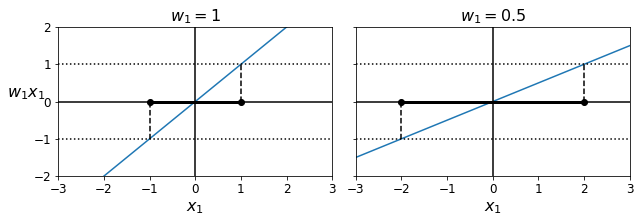

In [69]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

In [70]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

그림 저장: hinge_plot


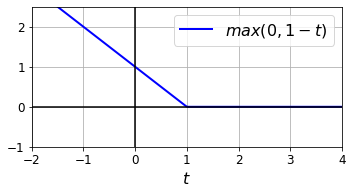

In [71]:
# 힌지 손실 
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

### 훈련시간

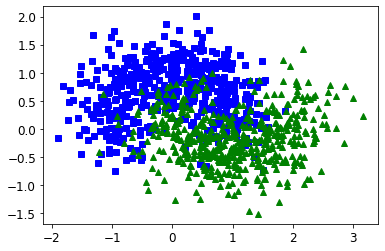

In [72]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.4031796455383301
[LibSVM]1 0.01 0.41668105125427246
[LibSVM]2 0.001 0.47676706314086914
[LibSVM]3 0.0001 0.995171070098877
[LibSVM]4 1e-05 1.6713814735412598
[LibSVM]5 1.0000000000000002e-06 1.4363248348236084
[LibSVM]6 1.0000000000000002e-07 24.298583269119263
[LibSVM]7 1.0000000000000002e-08 3.262291431427002
[LibSVM]8 1.0000000000000003e-09 1.9682626724243164
[LibSVM]9 1.0000000000000003e-10 1.573730230331421


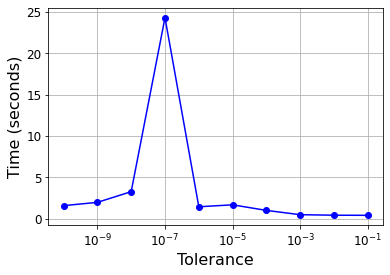

In [73]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

## 배치 경사 하강법을 사용한 선형 SVM 분류기 구현

In [74]:
# 훈련 세트
X = iris["data"][:, (2, 3)] # # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [75]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if y==0, +1 if y==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -self.C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

(0.0, 60000.0, 0.0, 100.0)

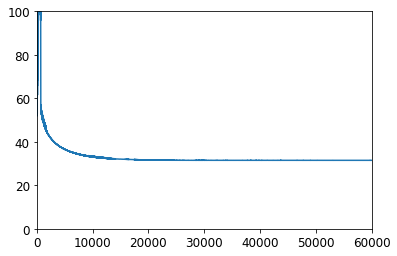

In [76]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [77]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [78]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

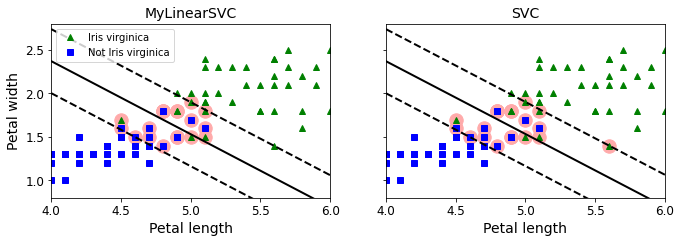

In [79]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

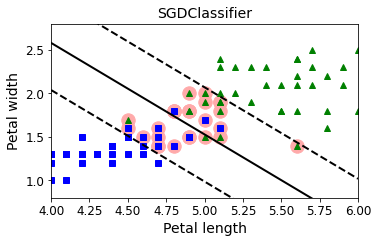

In [80]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # y==0이면 -1, y==1이면 +1
X_b = np.c_[np.ones((m, 1)), X]  # 편향 x0=1을 추가합니다
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])